In [1]:
!nvidia-smi

Sun Jun  4 17:36:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-sign
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization 
import random
import pickle
import pandas as pd
import cv2

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 117.80 MiB | 8.11 MiB/s, done.
ls: cannot access 'german-traffic-sign': No such file or directory


In [3]:
np.random.seed(0)

In [4]:
np.random.seed(0)
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [5]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
 
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [6]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

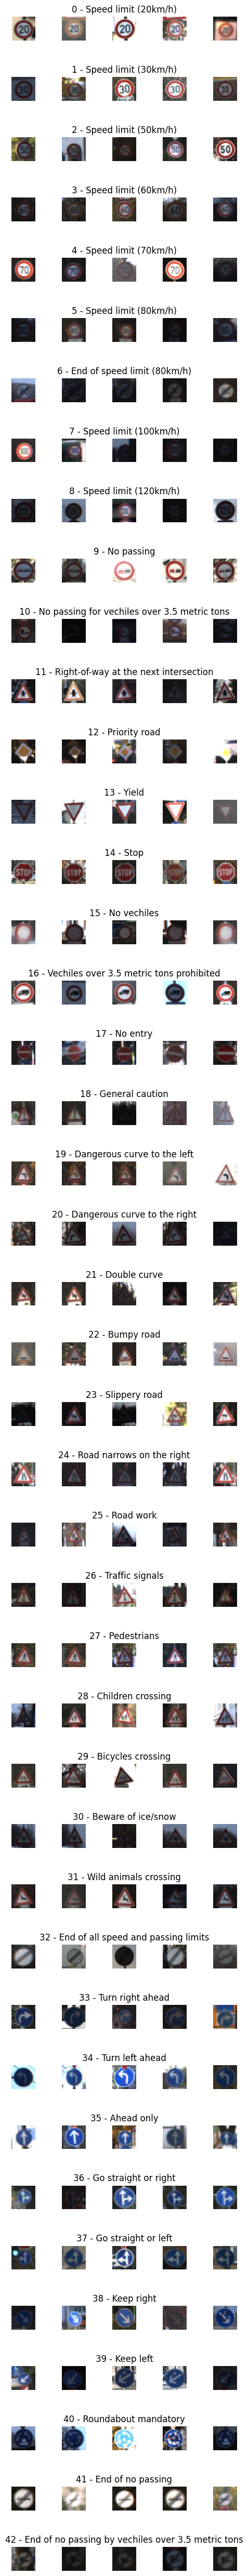

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


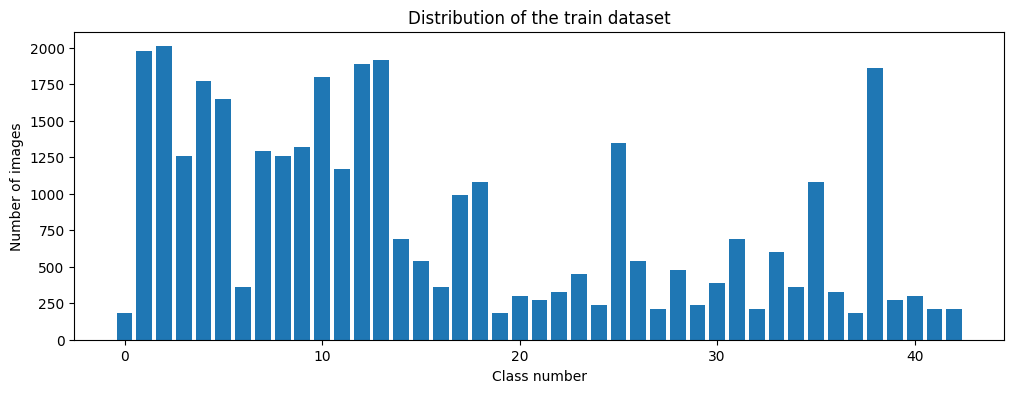

In [8]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


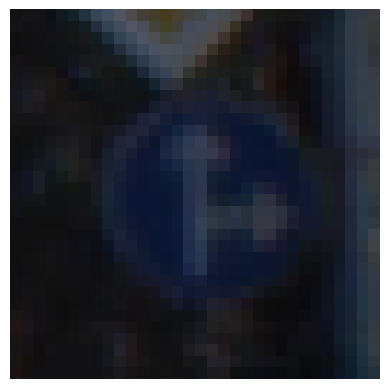

In [9]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)
(32, 32)
(34799, 32, 32)


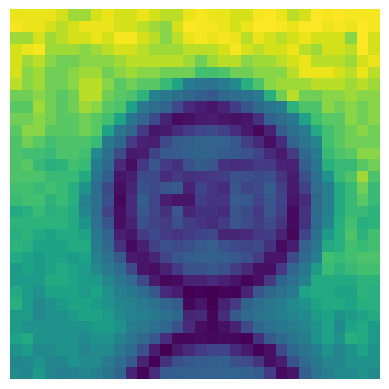

In [10]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    #img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [11]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
 
datagen.fit(X_train)

(20, 32, 32, 1)


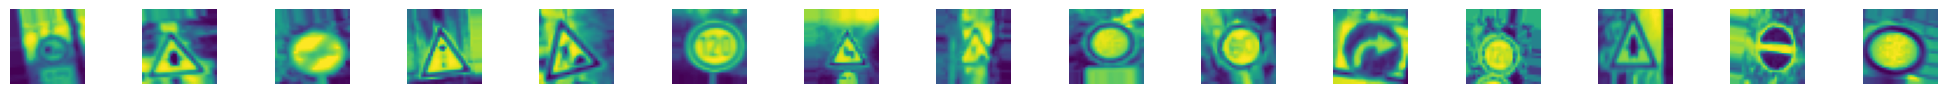

In [13]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [14]:
y_train = to_categorical(y_train, 43)
y_test_cat = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [15]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(32, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  
  model.add(Flatten())
  model.add(Dense(600, activation='relu'))
  #model.add(BatchNormalization())
  model.add(Dense(400, activation='relu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [16]:
model = modified_model()
print(model.summary())
 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=40),
                            
                            epochs=20,
                            validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 30)          17310     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-16-988fc5805b34>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=40),


None
Epoch 1/20
870/870 [==============================] - 25s 19ms/step - loss: 2.0897 - accuracy: 0.4140 - val_loss: 0.8692 - val_accuracy: 0.7168
Epoch 2/20
870/870 [==============================] - 17s 20ms/step - loss: 1.0231 - accuracy: 0.6826 - val_loss: 0.4852 - val_accuracy: 0.8454
Epoch 3/20
870/870 [==============================] - 16s 18ms/step - loss: 0.6815 - accuracy: 0.7871 - val_loss: 0.3079 - val_accuracy: 0.9082
Epoch 4/20
870/870 [==============================] - 15s 18ms/step - loss: 0.4890 - accuracy: 0.8480 - val_loss: 0.2082 - val_accuracy: 0.9397
Epoch 5/20
870/870 [==============================] - 16s 18ms/step - loss: 0.3755 - accuracy: 0.8814 - val_loss: 0.1506 - val_accuracy: 0.9546
Epoch 6/20
870/870 [==============================] - 16s 18ms/step - loss: 0.3021 - accuracy: 0.9069 - val_loss: 0.1202 - val_accuracy: 0.9635
Epoch 7/20
870/870 [==============================] - 16s 18ms/step - loss: 0.2445 - accuracy: 0.9248 - val_loss: 0.1350 - val_accu

Text(0.5, 0, 'epoch')

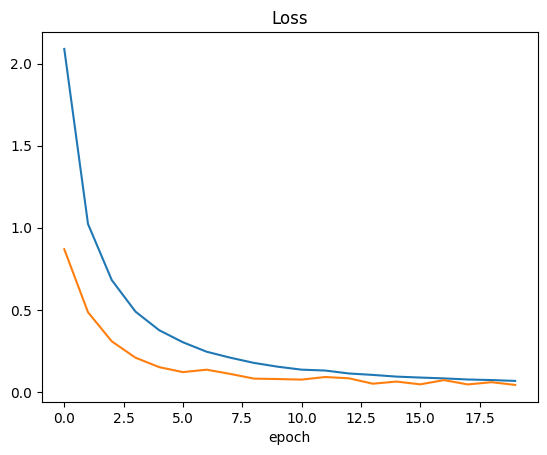

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
 

 
# TODO: Evaluate model on test data


Text(0.5, 0, 'epoch')

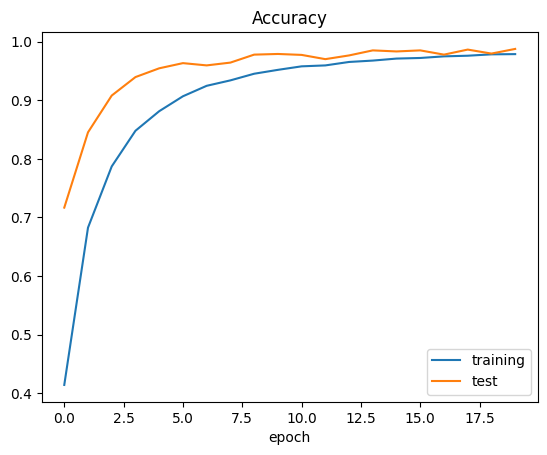

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [19]:
score = model.evaluate(X_test, y_test_cat, verbose=0)
print(score)

[0.17411796748638153, 0.9570863246917725]


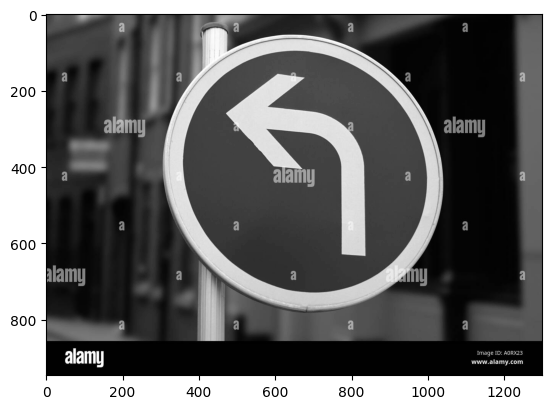

In [29]:
#print('Test score:', score[0])
#print('Test accuracy:', score[1])
 
#predict internet number
import numpy as np
import cv2
import matplotlib.pyplot as plt

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img2 = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 


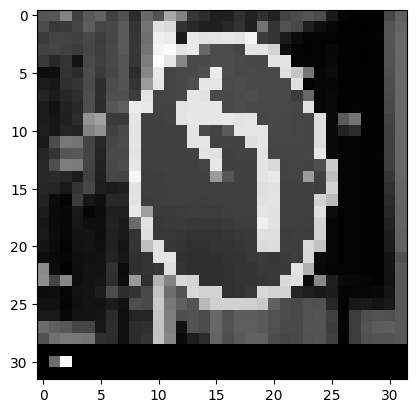

1/1 [==============================] - 0s 266ms/step
Predicted class:  [5]


In [35]:
img = img2.convert('L')
#Convert the PIL Image to a numpy array

img_array = np.array(img)

# Resize the image
img_array_resized = cv2.resize(img_array, (32, 32))

# Normalize the image
img_array_normalized = img_array_resized / 255.0

# Display the image
plt.imshow(img_array_normalized, cmap=plt.get_cmap('gray'))
plt.show()

# Add extra dimensions for batch and channels
img_array_normalized = img_array_normalized.reshape(1, 32, 32, 1)

# Use the model to predict the class
predicted_class = np.argmax(model.predict(img_array_normalized), axis=-1)
print("Predicted class: ", predicted_class)

In [36]:
from sklearn.metrics import classification_report

In [38]:
predictions = np.argmax(model.predict(X_test), axis=-1)


395/395 [==============================] - 1s 2ms/step


In [39]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        60
           1       1.00      0.97      0.98       720
           2       0.94      0.99      0.96       750
           3       0.97      0.98      0.97       450
           4       0.99      0.94      0.97       660
           5       0.97      0.92      0.95       630
           6       0.99      0.81      0.89       150
           7       0.99      0.98      0.99       450
           8       0.98      0.99      0.98       450
           9       1.00      0.97      0.98       480
          10       0.98      0.99      0.99       660
          11       0.93      0.95      0.94       420
          12       0.98      0.99      0.98       690
          13       1.00      1.00      1.00       720
          14       0.95      1.00      0.97       270
          15       1.00      0.85      0.92       210
          16       0.92      1.00      0.96       150
          17       1.00    